 Challenge:

    - Use the dataset Pump Sensor Data 
    - Plot the timeseries of sensor_00 against machine_status, comment on the behaviour
    - Create a correlation heatmap
    - Determine which 3 sensors are strongest predictors of failure
    - Build a classification model (Logistic Regression, Random Forest or XGBoost) to predict the machine_status
    - Upload your code or Jupyter notebook to your github.com repository


# import all dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

# Loading the Data and Basic Checks

In [2]:
# here we are Loading the file
file_path = r"C:\Users\H P\Downloads\AI\Smartbeam_ai_assignment\sensor.csv\sensor.csv"
df = pd.read_csv(file_path)

In [3]:
# Basic checks
print("Shape:", df.shape)
print("\nColumns (first 20):", df.columns.tolist()[:20])
print("\nLast 5 columns:", df.columns.tolist()[-5:])

Shape: (220320, 55)

Columns (first 20): ['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17']

Last 5 columns: ['sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status']


In [4]:
# Peek data
display(df.head(3))
display(df.tail(3))

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


In [5]:
# Checking target distribution (machine_status)
if "machine_status" in df.columns:
    print("\nmachine_status counts:")
    print(df["machine_status"].value_counts(dropna=False))
else:
    print("\n 'machine_status' column not found. Check column names above.")


machine_status counts:
machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


In [6]:
# Missing values summary
na_counts = df.isna().sum().sort_values(ascending=False)
print("\nTop missing columns:")
display(na_counts)


Top missing columns:


sensor_15         220320
sensor_50          77017
sensor_51          15383
sensor_00          10208
sensor_07           5451
sensor_08           5107
sensor_06           4798
sensor_09           4595
sensor_01            369
sensor_30            261
sensor_29             72
sensor_32             68
sensor_18             46
sensor_17             46
sensor_22             41
sensor_25             36
sensor_16             31
sensor_40             27
sensor_41             27
sensor_43             27
sensor_44             27
sensor_39             27
sensor_38             27
sensor_45             27
sensor_46             27
sensor_47             27
sensor_48             27
sensor_42             27
sensor_49             27
sensor_14             21
sensor_26             20
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_27             16


# Data Cleaning

In [7]:
#taking copy of df
df2 = df.copy()

# Droping index-like column
if "Unnamed: 0" in df2.columns:
    df2 = df2.drop(columns=["Unnamed: 0"])

# Parse timestamp and sort
df2["timestamp"] = pd.to_datetime(df2["timestamp"], errors="coerce")
df2 = df2.sort_values("timestamp").reset_index(drop=True)

print("Shape after cleanup:", df2.shape)
print("Any null timestamps?", df2["timestamp"].isna().sum())
df2.head(2)

Shape after cleanup: (220320, 54)
Any null timestamps? 0


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL


## Time Series Plot: sensor_00 vs machine_status

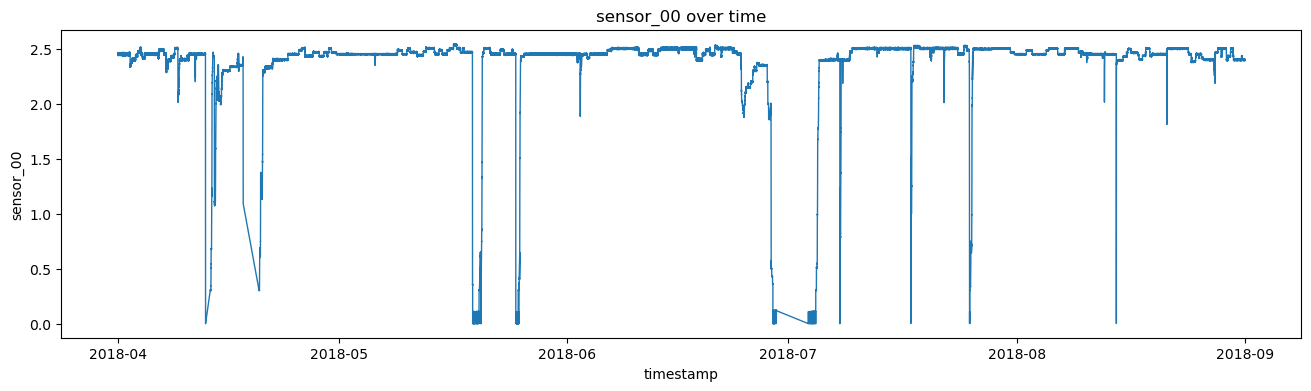

BROKEN rows: 7 [17155, 24510, 69318, 77790, 128040, 141131, 166440]


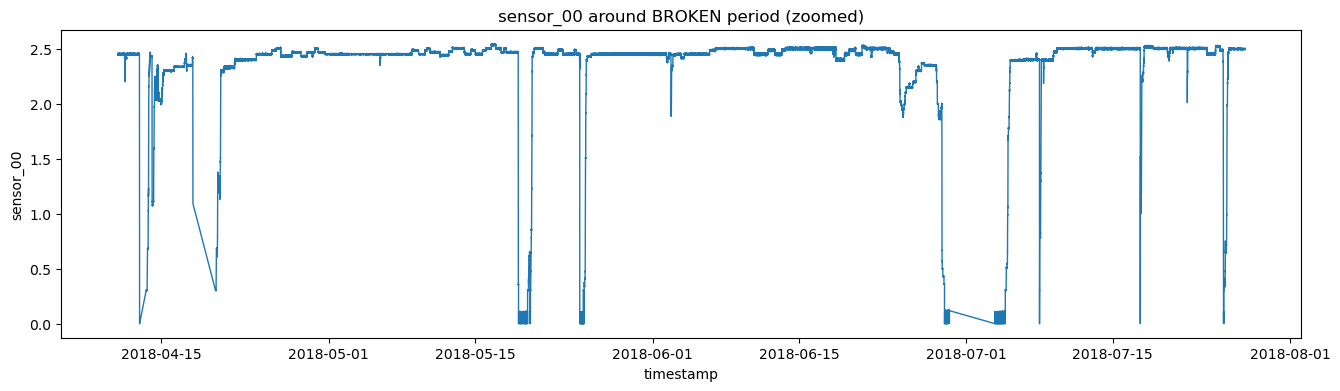

Zoom window status counts:
machine_status
NORMAL        140802
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


In [8]:
plot_df = df2[["timestamp", "sensor_00", "machine_status"]].copy()

# For plotting: fill gaps smoothly
plot_df["sensor_00_plot"] = plot_df["sensor_00"].interpolate(limit_direction="both")

plt.figure(figsize=(16,4))
plt.plot(plot_df["timestamp"], plot_df["sensor_00_plot"], linewidth=1)
plt.title("sensor_00 over time")
plt.xlabel("timestamp")
plt.ylabel("sensor_00")
plt.show()

# Zoom around BROKEN area (since only 7 points, we want context)
broken_idx = plot_df.index[plot_df["machine_status"] == "BROKEN"].to_list()
print("BROKEN rows:", len(broken_idx), broken_idx[:10])

if len(broken_idx) > 0:
    i0 = max(min(broken_idx) - 3000, 0)
    i1 = min(max(broken_idx) + 3000, len(plot_df)-1)

    plt.figure(figsize=(16,4))
    plt.plot(plot_df.loc[i0:i1, "timestamp"], plot_df.loc[i0:i1, "sensor_00_plot"], linewidth=1)
    plt.title("sensor_00 around BROKEN period (zoomed)")
    plt.xlabel("timestamp")
    plt.ylabel("sensor_00")
    plt.show()

    print("Zoom window status counts:")
    print(plot_df.loc[i0:i1, "machine_status"].value_counts())

## comments on sensor_00 behaviour.

## Based on plot:

#### sensor_00 stays mostly stable around ~2.4–2.55 for long periods when the machine is NORMAL.

#### At multiple points it shows sudden sharp drops (near 0) and short unstable segments, after which it returns back to the normal band.

#### The BROKEN events are extremely rare (only 7 rows), but they occur during periods where the signal shows abrupt discontinuities / near-zero dips, suggesting abnormal sensor behaviour around failure timestamps.

#### RECOVERING occurs in the same broad window as disturbances, indicating the machine transitions through recovery phases after abnormal readings.

# Correlation Heatmap

Why we do it:
To see which sensors move together. If many sensors are strongly correlated, they may be redundant.

Important cleanup before correlation:
sensor_15 is 100% missing so drop
For correlation, we are filling missing values

Dropping fully-missing sensors: ['sensor_15']


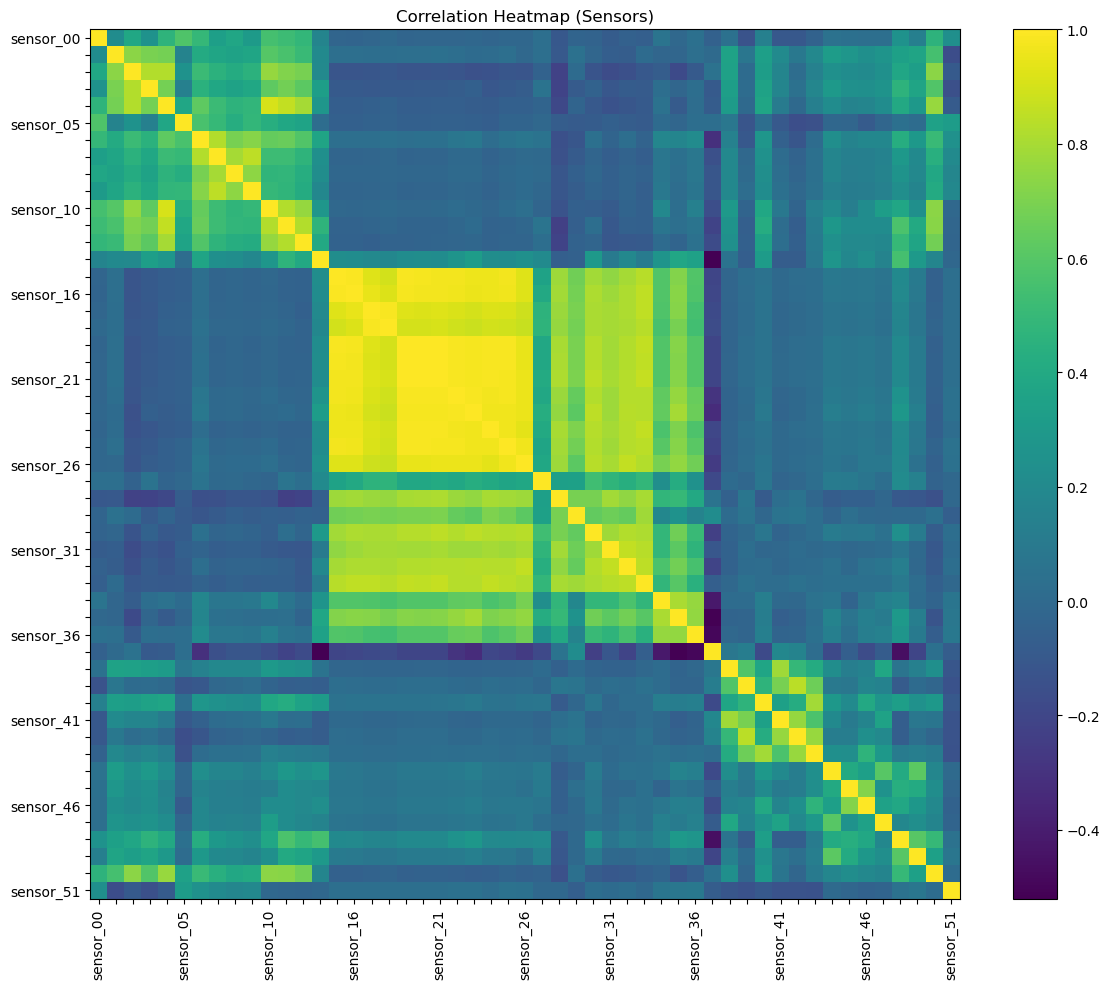

In [9]:
# Sensor columns
sensor_cols = [c for c in df2.columns if c.startswith("sensor_")]

# Drop fully-missing columns (sensor_15 is removed here)
na_all = df2[sensor_cols].isna().all()
drop_cols = na_all[na_all].index.tolist()
print("Dropping fully-missing sensors:", drop_cols)

sensor_cols_clean = [c for c in sensor_cols if c not in drop_cols]

# Prepare numeric matrix for correlation
X_corr = df2[sensor_cols_clean].copy()
X_corr = X_corr.apply(lambda s: s.fillna(s.median()), axis=0)

# speed-up: sample rows (correlation is stable even with sample)
X_corr_sample = X_corr.sample(n=50000, random_state=42) if len(X_corr) > 50000 else X_corr

corr = X_corr_sample.corr()

# Plotting heatmap using matplotlib
plt.figure(figsize=(14, 10))
plt.imshow(corr.values)
plt.title("Correlation Heatmap (Sensors)")
plt.colorbar(fraction=0.046, pad=0.04)

# showing every 5th label to keep readable
step = 5
labels = corr.columns.tolist()
plt.xticks(range(len(labels)), [labels[i] if i % step == 0 else "" for i in range(len(labels))], rotation=90)
plt.yticks(range(len(labels)), [labels[i] if i % step == 0 else "" for i in range(len(labels))])

plt.tight_layout()
plt.show()

# Sensors strongest predictors of failure

This will:

- find the timestamp of each BROKEN row
- plot sensor_00 in a small time window around it (e.g., ±6 hours)
- show the status counts in that window

Total BROKEN rows: 7


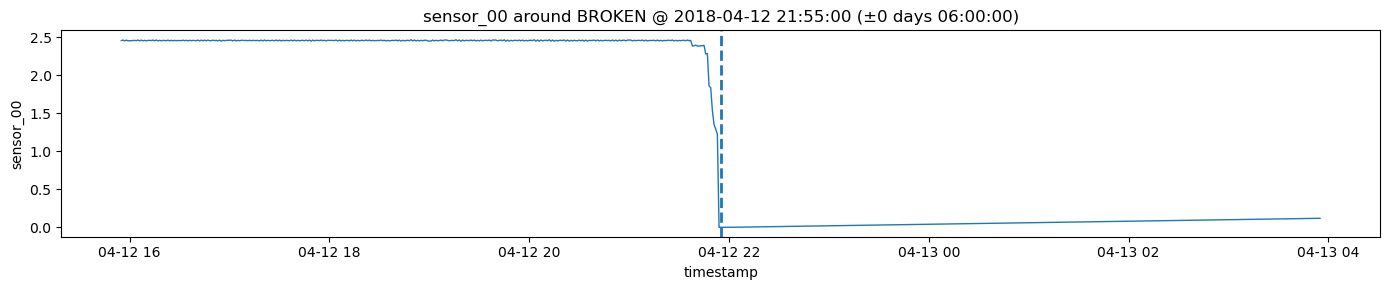


BROKEN @ 2018-04-12 21:55:00 | window rows=721
machine_status
NORMAL        360
RECOVERING    360
BROKEN          1
Name: count, dtype: int64


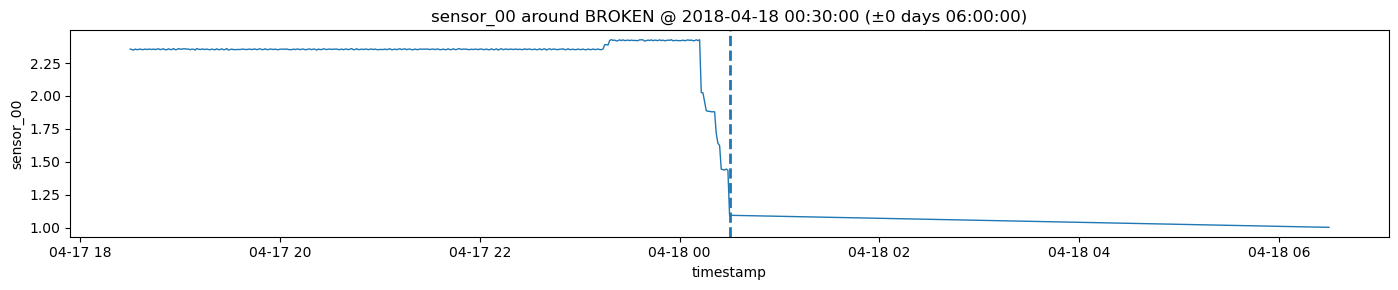


BROKEN @ 2018-04-18 00:30:00 | window rows=721
machine_status
NORMAL        360
RECOVERING    360
BROKEN          1
Name: count, dtype: int64


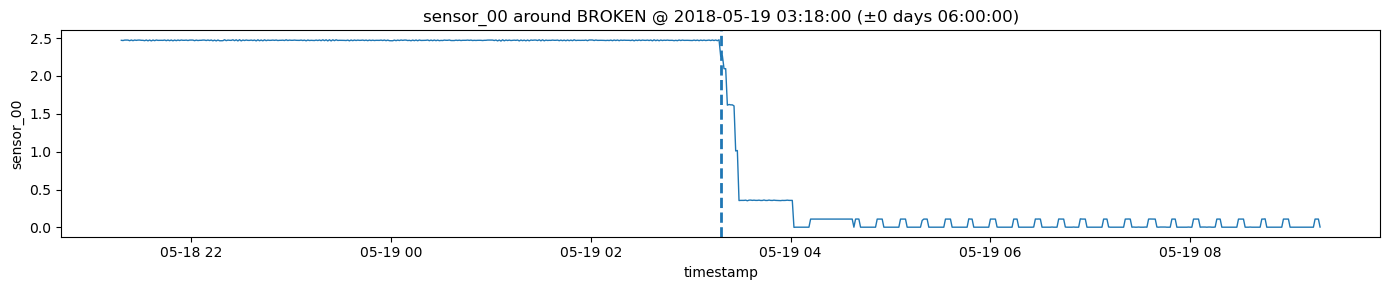


BROKEN @ 2018-05-19 03:18:00 | window rows=721
machine_status
NORMAL        360
RECOVERING    360
BROKEN          1
Name: count, dtype: int64


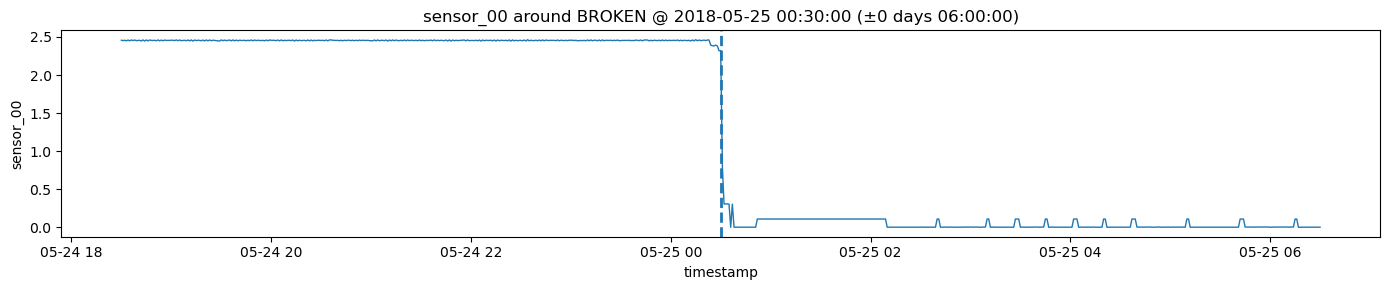


BROKEN @ 2018-05-25 00:30:00 | window rows=721
machine_status
NORMAL        360
RECOVERING    360
BROKEN          1
Name: count, dtype: int64


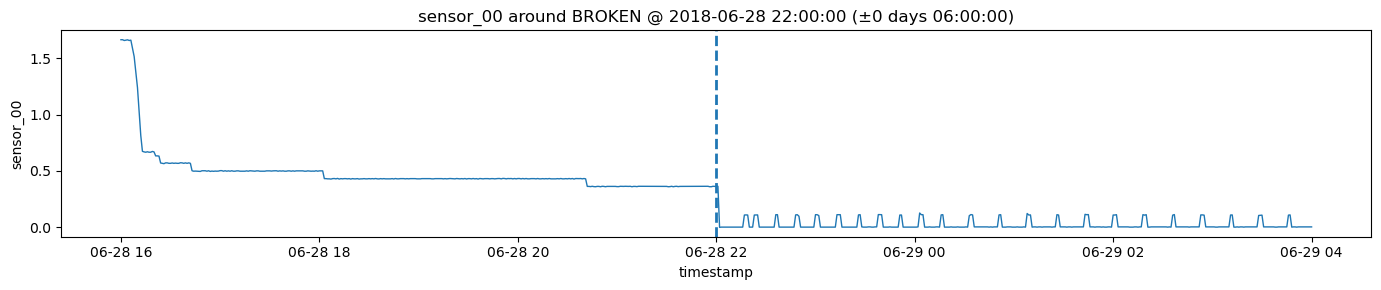


BROKEN @ 2018-06-28 22:00:00 | window rows=721
machine_status
NORMAL        360
RECOVERING    360
BROKEN          1
Name: count, dtype: int64


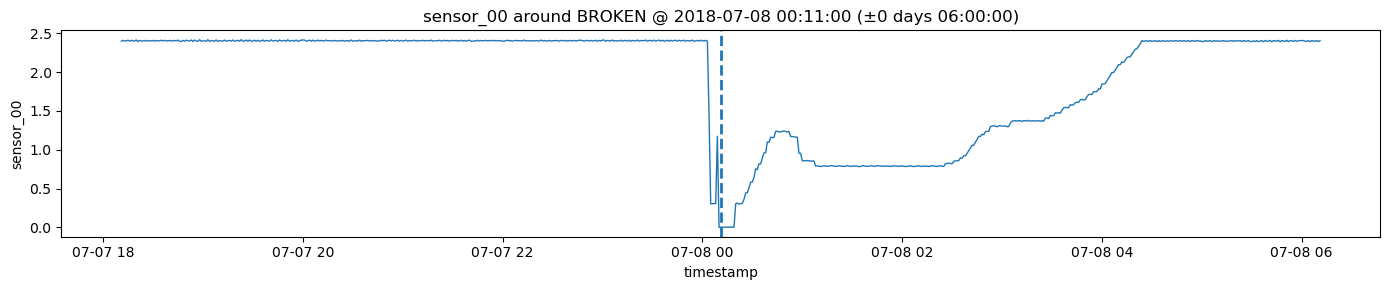


BROKEN @ 2018-07-08 00:11:00 | window rows=721
machine_status
NORMAL        679
RECOVERING     41
BROKEN          1
Name: count, dtype: int64


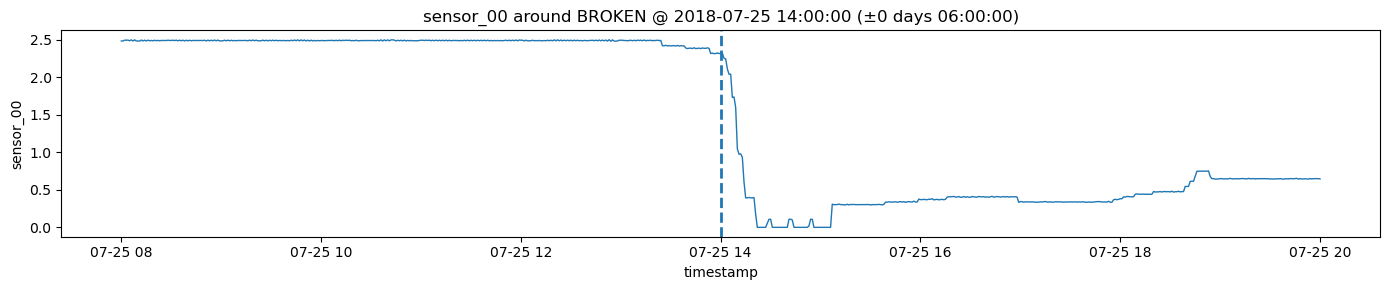


BROKEN @ 2018-07-25 14:00:00 | window rows=721
machine_status
NORMAL        645
RECOVERING     75
BROKEN          1
Name: count, dtype: int64


In [10]:
plot_df = df2[["timestamp", "sensor_00", "machine_status"]].copy()
plot_df["sensor_00_plot"] = plot_df["sensor_00"].interpolate(limit_direction="both")

broken_rows = plot_df[plot_df["machine_status"] == "BROKEN"].copy()
print("Total BROKEN rows:", len(broken_rows))

# window size taking 6 hr
window = pd.Timedelta("6H")

for idx, row in broken_rows.iterrows():
    t_fail = row["timestamp"]
    start = t_fail - window
    end = t_fail + window

    w = plot_df[(plot_df["timestamp"] >= start) & (plot_df["timestamp"] <= end)].copy()

    # Plot
    plt.figure(figsize=(14, 3))
    plt.plot(w["timestamp"], w["sensor_00_plot"], linewidth=1)
    plt.axvline(t_fail, linestyle="--", linewidth=2)  # failure moment
    plt.title(f"sensor_00 around BROKEN @ {t_fail} (±{window})")
    plt.xlabel("timestamp")
    plt.ylabel("sensor_00")
    plt.tight_layout()
    plt.show()

    print(f"\nBROKEN @ {t_fail} | window rows={len(w)}")
    print(w["machine_status"].value_counts())

#### What your per-BROKEN zoom clearly shows?

##### Across all 7 failure timestamps, sensor_00 shows a sharp step-change/drop from its normal operating band (~2.4–2.5) to very low values (near 0–0.5) at/just before the BROKEN timestamp (vertical dashed line).

##### After the drop, the signal often remains depressed for hours, with small oscillations, and in some cases shows recovery/ramp-up back toward normal values (notably around 2018-07-08 and 2018-07-25).

##### In most failure windows, the surrounding labels show a mix of NORMAL and RECOVERING, suggesting that failures occur during unstable transitions and recovery periods.

### Heatmap:

#### heatmap has obvious bright yellow blocks → strong correlation groups.

#### The correlation heatmap shows distinct clusters of highly correlated sensors (block patterns), indicating groups of sensors measuring related behaviour / redundant signals.

#### Some sensor blocks have strong positive correlation (yellow regions), while other pairs show weak or negative correlation (blue/purple), suggesting multiple independent subsystems.

#### Due to redundancy, tree-based models can select representative sensors from each cluster, and feature importance can highlight the most predictive ones.

# Determine 3 sensors strongest predictors of failure

- Creating binary target: failure = 1 if BROKEN else 0
- Using a model (XGBoost) with imbalance weight
- Using permutation importance to rank sensors
- Reporting top 3

In [11]:
# Setup columns
dfm = df2.copy()
dfm["failure"] = (dfm["machine_status"] == "BROKEN").astype(int)

sensor_cols = [c for c in dfm.columns if c.startswith("sensor_")]
# drop fully missing sensors (sensor_15)
drop_cols = dfm[sensor_cols].columns[dfm[sensor_cols].isna().all()].tolist()
sensor_cols = [c for c in sensor_cols if c not in drop_cols]
print("Dropped sensors:", drop_cols)

# X and y (median impute)
X = dfm[sensor_cols].copy()
X = X.apply(lambda s: s.fillna(s.median()), axis=0)
y = dfm["failure"].astype(int)

print("Failure counts:\n", y.value_counts())

# Use ALL data for importance BUT evaluate importance on a small test window around failures
# We will make "importance set" = ±6 hours around each BROKEN timestamp so it actually contains failures.
broken_times = dfm.loc[dfm["failure"] == 1, "timestamp"].sort_values().tolist()
window = pd.Timedelta("6H")

imp_mask = pd.Series(False, index=dfm.index)
for t in broken_times:
    imp_mask |= dfm["timestamp"].between(t - window, t + window)

X_imp = X[imp_mask]
y_imp = y[imp_mask]
print("Importance window rows:", X_imp.shape[0], "Failures in window:", int(y_imp.sum()))

# Train model on full data (best use of rare failures)
neg = (y == 0).sum()
pos = (y == 1).sum()
scale_pos_weight = neg / max(pos, 1)
print("scale_pos_weight:", scale_pos_weight)

xgb_fail = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
xgb_fail.fit(X, y)

# Permutation importance on failure windows
perm = permutation_importance(
    xgb_fail, X_imp, y_imp,
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

imp = pd.Series(perm.importances_mean, index=sensor_cols).sort_values(ascending=False)
display(imp.head(15))
print("Top 3 strongest predictors of failure:", list(imp.head(3).index))

Dropped sensors: ['sensor_15']
Failure counts:
 failure
0    220313
1         7
Name: count, dtype: int64
Importance window rows: 5047 Failures in window: 7
scale_pos_weight: 31473.285714285714


sensor_40    0.001202
sensor_51    0.000674
sensor_00    0.000396
sensor_04    0.000370
sensor_37    0.000317
sensor_36    0.000119
sensor_39    0.000053
sensor_03    0.000000
sensor_30    0.000000
sensor_31    0.000000
sensor_32    0.000000
sensor_33    0.000000
sensor_34    0.000000
sensor_35    0.000000
sensor_38    0.000000
dtype: float64

Top 3 strongest predictors of failure: ['sensor_40', 'sensor_51', 'sensor_00']


# Building classification model to predict machine_status (multi-class)

- Now we build model to predict:
NORMAL, RECOVERING, BROKEN

- Key issue

- BROKEN has only 7 rows, so many models will miss it.
- We will do XGBoost multi-class + sample weights so BROKEN gets attention, without creating synthetic data.

# Creating train/test for multi-class machine_status

In [12]:
dfc = df2.copy()

# Features
sensor_cols = [c for c in dfc.columns if c.startswith("sensor_")]
drop_cols = dfc[sensor_cols].columns[dfc[sensor_cols].isna().all()].tolist()
sensor_cols = [c for c in sensor_cols if c not in drop_cols]
print("Dropped sensors:", drop_cols)

X_all = dfc[sensor_cols].copy().apply(lambda s: s.fillna(s.median()), axis=0)
y_all = dfc["machine_status"].astype(str).str.upper().str.strip()

print("Overall class counts:\n", y_all.value_counts())

# Test windows around last 2 BROKEN events (same as before, but for multiclass)
broken_times = dfc.loc[y_all == "BROKEN", "timestamp"].sort_values().tolist()
print("BROKEN timestamps:", broken_times)

test_failures = broken_times[-2:]   # last 2 failures in test
window = pd.Timedelta("6H")

test_mask = pd.Series(False, index=dfc.index)
for t in test_failures:
    test_mask |= dfc["timestamp"].between(t - window, t + window)

X_train, y_train = X_all[~test_mask], y_all[~test_mask]
X_test, y_test = X_all[test_mask], y_all[test_mask]

print("\nTrain counts:\n", y_train.value_counts())
print("\nTest counts:\n", y_test.value_counts())

Dropped sensors: ['sensor_15']
Overall class counts:
 machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64
BROKEN timestamps: [Timestamp('2018-04-12 21:55:00'), Timestamp('2018-04-18 00:30:00'), Timestamp('2018-05-19 03:18:00'), Timestamp('2018-05-25 00:30:00'), Timestamp('2018-06-28 22:00:00'), Timestamp('2018-07-08 00:11:00'), Timestamp('2018-07-25 14:00:00')]

Train counts:
 machine_status
NORMAL        204512
RECOVERING     14361
BROKEN             5
Name: count, dtype: int64

Test counts:
 machine_status
NORMAL        1324
RECOVERING     116
BROKEN           2
Name: count, dtype: int64


# Training classification model (XGBoost) to predict machine_status

Classes: ['BROKEN', 'NORMAL', 'RECOVERING']
Class weights: {'BROKEN': 43775.6, 'NORMAL': 1.0702452667814113, 'RECOVERING': 15.241139196434789}

=== Classification Report (machine_status) ===
              precision    recall  f1-score   support

      BROKEN     0.0000    0.0000    0.0000         2
      NORMAL     0.9233    1.0000    0.9601      1324
  RECOVERING     1.0000    0.0690    0.1290       116

    accuracy                         0.9237      1442
   macro avg     0.6411    0.3563    0.3630      1442
weighted avg     0.9282    0.9237    0.8919      1442



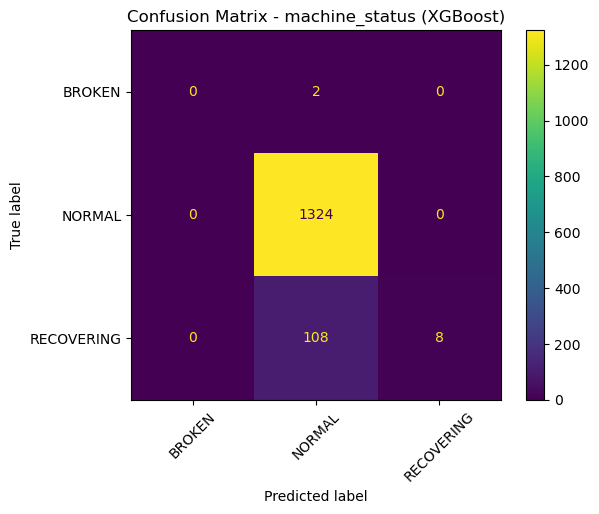

In [13]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Classes:", list(le.classes_))  # e.g. ['BROKEN','NORMAL','RECOVERING']

# Class weights (inverse frequency) -> converted to sample_weight
counts = np.bincount(y_train_enc)
class_w = {i: (len(y_train_enc) / counts[i]) for i in range(len(counts))}
sample_weight = np.array([class_w[c] for c in y_train_enc])

print("Class weights:", {le.inverse_transform([k])[0]: v for k, v in class_w.items()})

# Train XGB multi-class
xgb_mc = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    n_estimators=800,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="mlogloss",
    n_jobs=-1
)

xgb_mc.fit(X_train, y_train_enc, sample_weight=sample_weight)

pred_enc = xgb_mc.predict(X_test)
pred = le.inverse_transform(pred_enc)

print("\n=== Classification Report (machine_status) ===")
print(classification_report(y_test, pred, digits=4, zero_division=0))

# Confusion matrix
labels = list(le.classes_)
cm = confusion_matrix(y_test, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - machine_status (XGBoost)")
plt.show()